导入库

In [1]:
import tensorflow as tf
import numpy as np
import mnist_data
import os
# import beta_vae as vae
import vae
import plot_utils
import glob
import random
import matplotlib.pyplot as plt
import cv2

配置参数

In [2]:
#gpu
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#图像尺寸
IMAGE_SIZE_MNIST = 28
#隐变量维度
dim_z=20
#隐层节点数
n_hidden=500
#学习率
learn_rate=1e-3
#训练轮数
n_epochs=20
#批量数目
batch_size=128
#标签样式 one-hot编码
one_hot=np.eye(10)
#结果保存路径
path=os.path.join(os.getcwd(),'result')
if not os.path.exists(path):
    os.system('mkdir '+path)
RESULTS_DIR=path
#是否加入噪声，denoise vae
ADD_NOISE=False
dim_img = IMAGE_SIZE_MNIST**2
#beta-vae
beta=2.0
#画图
PRR=True
PRR_n_img_x=10
PRR_n_img_y=10
PRR_resize_factor=1.0
PMLR=False
PMLR_n_img_x=20
PMLR_n_img_y=20
PMLR_resize_factor=1.0
PMLR_z_range=2.0
PMLR_n_samples=5000

准备target domain 数据

In [3]:
train_total_data, train_size, _, _, test_data, test_labels = mnist_data.prepare_MNIST_data()

W0916 15:30:37.407351 140308698335040 deprecation_wrapper.py:119] From /home/yuemei.zhu/tensorflow-mnist-VAE/mnist_data.py:30: The name tf.gfile.Exists is deprecated. Please use tf.io.gfile.exists instead.



Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [4]:
choose_c=6
ind=np.zeros(train_total_data.shape[0])
unbanlance_p=0.5
for p in range(train_total_data.shape[0]):
    ind[p]=np.argmax(train_total_data[p,-10:])
no_c_array=train_total_data[~np.equal(ind,choose_c)]
c_array=train_total_data[np.equal(ind,choose_c)]
remain=int(c_array.shape[0]*unbanlance_p)
train_unbanlance_data=np.concatenate([no_c_array,c_array[:remain]],axis=0)

In [5]:
no_c_array.shape[0]+c_array.shape[0]

55000

In [6]:
train_unbanlance_data.shape

(52291, 794)

In [7]:

""" build graph """
# input placeholders
# In denoising-autoencoder, x_hat == x + noise, otherwise x_hat == x
x_hat = tf.placeholder(tf.float32, shape=[None, dim_img], name='input_img')
x = tf.placeholder(tf.float32, shape=[None, dim_img], name='target_img')

# dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# input for PMLR
z_in = tf.placeholder(tf.float32, shape=[None, dim_z], name='latent_variable')

#vae
y, z, loss, neg_marginal_likelihood, KL_divergence = vae.autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob)

# network architecture beta vae
# y, z, loss, neg_marginal_likelihood, KL_divergence = vae.autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob,beta)

# optimization
train_op = tf.train.AdamOptimizer(learn_rate).minimize(loss)

decoded = vae.decoder(z_in, dim_img, n_hidden)

W0916 15:30:38.760454 140308698335040 deprecation_wrapper.py:119] From /home/yuemei.zhu/tensorflow-mnist-VAE/vae.py:5: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0916 15:30:39.566713 140308698335040 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0916 15:30:39.568409 140308698335040 deprecation_wrapper.py:119] From /home/yuemei.zhu/tensorflow-mnist-VAE/vae.py:11: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0916 15:30:39.583563 140308698335040 deprecation.py:506] From /home/yuemei.zhu/tensorflow-mnist-VAE/vae.py:15: calling dropout (from tensorflow.python.ops.nn_op

In [9]:
np.random.seed(100)
# n_samples=train_size
n_samples=train_unbanlance_data.shape[0]
""" training """

# Plot for reproduce performance
if PRR:
    PRR = plot_utils.Plot_Reproduce_Performance(RESULTS_DIR, PRR_n_img_x, PRR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PRR_resize_factor)

    x_PRR = test_data[0:PRR.n_tot_imgs, :]

    x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
    PRR.save_images(x_PRR_img, name='input.jpg')

    if ADD_NOISE:
        x_PRR = x_PRR * np.random.randint(2, size=x_PRR.shape)
        x_PRR += np.random.randint(2, size=x_PRR.shape)

        x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
        PRR.save_images(x_PRR_img, name='input_noise.jpg')

# Plot for manifold learning result
if PMLR and dim_z == 2:

    PMLR = plot_utils.Plot_Manifold_Learning_Result(RESULTS_DIR, PMLR_n_img_x, PMLR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PMLR_resize_factor, PMLR_z_range)

    x_PMLR = test_data[0:PMLR_n_samples, :]
    id_PMLR = test_labels[0:PMLR_n_samples, :]

    if ADD_NOISE:
        x_PMLR = x_PMLR * np.random.randint(2, size=x_PMLR.shape)
        x_PMLR += np.random.randint(2, size=x_PMLR.shape)

    decoded = vae.decoder(z_in, dim_img, n_hidden)
total_batch = int(n_samples / batch_size)
min_tot_loss = 1e99
sess=tf.Session()
# with tf.Session() as sess:

sess.run(tf.global_variables_initializer(), feed_dict={keep_prob : 0.9})

for epoch in range(n_epochs):

    # Random shuffling
    np.random.shuffle(train_unbanlance_data)
    train_data_ = train_unbanlance_data[:, :-mnist_data.NUM_LABELS]
    # Loop over all batches
    for i in range(total_batch):
        # Compute the offset of the current minibatch in the data.
        offset = (i * batch_size) % (n_samples)
        batch_xs_input = train_data_[offset:(offset + batch_size), :]

        batch_xs_target = batch_xs_input

        # add salt & pepper noise
        if ADD_NOISE:
            batch_xs_input = batch_xs_input * np.random.randint(2, size=batch_xs_input.shape)
            batch_xs_input += np.random.randint(2, size=batch_xs_input.shape)

        _, tot_loss, loss_likelihood, loss_divergence = sess.run(
            (train_op, loss, neg_marginal_likelihood, KL_divergence),
            feed_dict={x_hat: batch_xs_input, x: batch_xs_target, keep_prob : 0.9})

    # print cost every epoch
    print("epoch %d: L_tot %03.2f L_likelihood %03.2f L_divergence %03.2f" % (epoch, tot_loss, loss_likelihood, loss_divergence))

    # if minimum loss is updated or final epoch, plot results
    if min_tot_loss > tot_loss or epoch+1 == n_epochs:
        min_tot_loss = tot_loss
        # Plot for reproduce performance
        if PRR:
            y_PRR = sess.run(y, feed_dict={x_hat: x_PRR, keep_prob : 1})
            y_PRR_img = y_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
            PRR.save_images(y_PRR_img, name="/PRR_epoch_%02d" %(epoch) + ".jpg")

        # Plot for manifold learning result
        if PMLR and dim_z == 2:
            y_PMLR = sess.run(decoded, feed_dict={z_in: PMLR.z, keep_prob : 1})
            y_PMLR_img = y_PMLR.reshape(PMLR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
            PMLR.save_images(y_PMLR_img, name="/PMLR_epoch_%02d" % (epoch) + ".jpg")

            # plot distribution of labeled images
            z_PMLR = sess.run(z, feed_dict={x_hat: x_PMLR, keep_prob : 1})
            PMLR.save_scattered_image(z_PMLR,id_PMLR, name="/PMLR_map_epoch_%02d" % (epoch) + ".jpg")


epoch 0: L_tot 130.23 L_likelihood 106.23 L_divergence 23.99
epoch 1: L_tot 125.39 L_likelihood 101.11 L_divergence 24.28
epoch 2: L_tot 124.80 L_likelihood 99.74 L_divergence 25.06
epoch 3: L_tot 120.62 L_likelihood 96.49 L_divergence 24.13
epoch 4: L_tot 115.26 L_likelihood 91.44 L_divergence 23.82
epoch 5: L_tot 114.03 L_likelihood 90.35 L_divergence 23.68
epoch 6: L_tot 115.81 L_likelihood 91.80 L_divergence 24.01
epoch 7: L_tot 111.42 L_likelihood 87.57 L_divergence 23.85
epoch 8: L_tot 114.10 L_likelihood 89.94 L_divergence 24.16
epoch 9: L_tot 108.30 L_likelihood 84.78 L_divergence 23.52
epoch 10: L_tot 110.38 L_likelihood 86.55 L_divergence 23.83
epoch 11: L_tot 114.67 L_likelihood 90.57 L_divergence 24.10
epoch 12: L_tot 111.85 L_likelihood 88.23 L_divergence 23.62
epoch 13: L_tot 111.23 L_likelihood 87.86 L_divergence 23.38
epoch 14: L_tot 110.45 L_likelihood 87.06 L_divergence 23.40
epoch 15: L_tot 109.21 L_likelihood 85.39 L_divergence 23.82
epoch 16: L_tot 111.12 L_likelih

选定一个类别，准备数据

例如：针对类别3，将训练集数据中类别3的样本组成数组

In [11]:
choose_c=6
c=0
for p in range(train_unbanlance_data.shape[0]):
    if np.argmax(train_unbanlance_data[p,-10:])==choose_c:
        c+=1

target_domain_size=c
print('target domain',target_domain_size)

k3=np.zeros([target_domain_size,784])
c=0
for p in range(train_unbanlance_data.shape[0]):
    if np.argmax(train_unbanlance_data[p,-10:])==choose_c:
        k3[c]=train_unbanlance_data[p,:-10]
        c+=1
#         if c == 10:
#             print('target domain test count')
#             plt.imshow(train_total_data[p,:-10].reshape([28,28]))
#             plt.show()
#设置batch size
target_batch = int(target_domain_size / batch_size)

#同一类别的隐变量
vec_ari_a=np.zeros([target_batch*batch_size,dim_z])
for offset in range(target_batch):
    x_batch=k3[offset*batch_size:(offset+1)*batch_size]
    z_batch = sess.run(z, feed_dict={x_hat: x_batch, keep_prob : 1})
    vec_ari_a[offset*batch_size:(offset+1)*batch_size]=z_batch
mu_,sigma_=vec_ari_a.mean(axis=0),vec_ari_a.std(axis=0)

target domain 2708


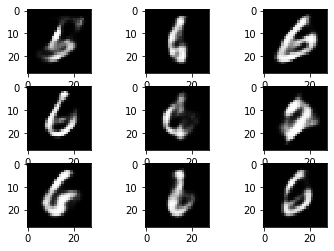

In [12]:
c=0
plt.figure
for i in range(3):
    for j in range(3):
        z_sample_=mu_ + sigma_ * np.random.normal(0.0,1.0,mu_.shape)
        y_PMLR = sess.run(decoded, feed_dict={z_in: z_sample_.reshape([1,-1]), keep_prob : 1})
        np.clip(y_PMLR,1e-8, 1 - 1e-8,out=y_PMLR)
        loc=''.join([str(3),str(3),str(c+1)])
        plt.subplot(eval(loc))
        plt.imshow(y_PMLR.reshape([28,28]),cmap='gray')
        c+=1
plt.show()